In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy import stats
from scipy.stats import false_discovery_control
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import random
import matplotlib.pyplot as plt
from rdkit import Chem
import math

In [2]:
# Nature-style rcParams
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8,
    'axes.linewidth': 0.5,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

In [3]:
with open("FinalBDBPredTrain.txt", "r") as file:
    txt = file.read()
    lines = txt.split("\n")

In [4]:
trainligands = [eval(lines[i]) + eval(lines[i+1]) for i in range(1, len(lines), 7)]

In [5]:
names = lines[::7]

In [6]:
obdb = pd.read_csv(f"FinalBDBPred.csv")

In [7]:
adlifts = []
adAUCs = []
adCurves = []
for j, name in enumerate(names):
    bdb = obdb.drop(trainligands[j])

    bdb_classes = bdb["Sub_Class"].tolist()
    bdb_types = set(bdb_classes)
    bdb_class_to_indices = {x:list() for x in bdb_types}
    for i, val in enumerate(bdb_classes):
        bdb_class_to_indices[val].append(i)
    bdb_counts = {x:len(y) for x, y in bdb_class_to_indices.items()}

    cutoff = len(bdb_classes) // 100
    prediction = bdb[name].tolist()
    correct = len([x for x in sorted(range(len(bdb_classes)), key=lambda i: prediction[i])[-cutoff:] if bdb_classes[x] == name])
    
    adlifts.append((name, correct*len(bdb_classes)/(cutoff*len(bdb_class_to_indices[name]))))
    adAUCs.append((name, roc_auc_score([1 if x == name else 0 for x in bdb["Sub_Class"]], bdb[name])))
    
    fprs, tprs, _ = roc_curve([1 if x == name else 0 for x in bdb["Sub_Class"]], bdb[name])
    adCurves.append((fprs, tprs))

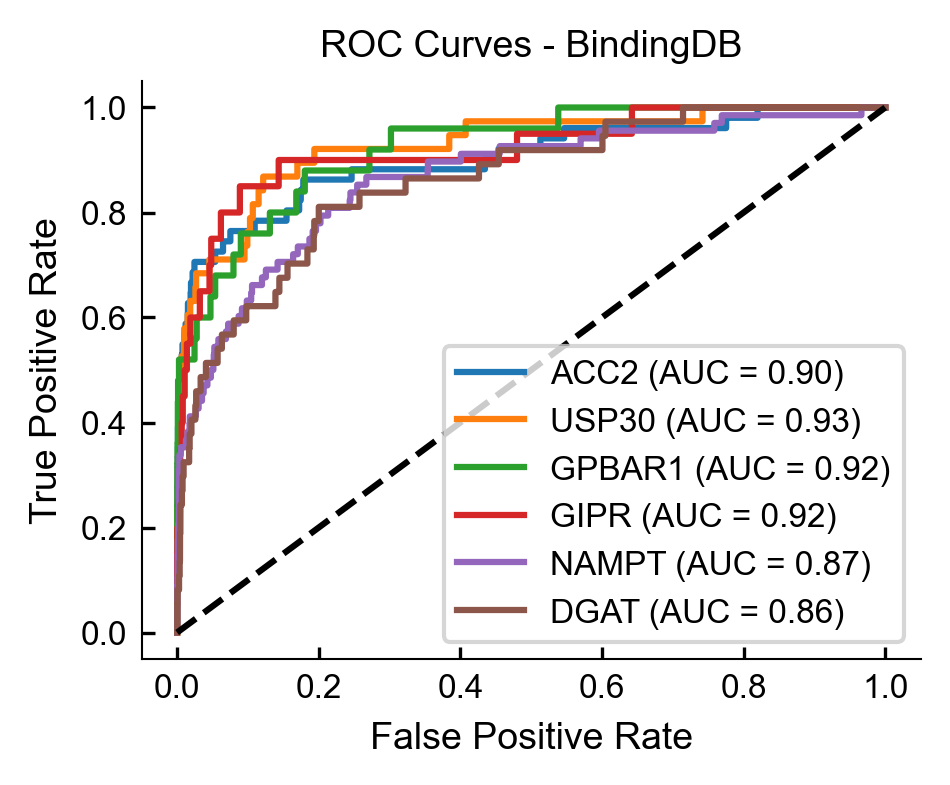

In [10]:
altnames = {"ACC2":"ACC2", "USP30":"USP30",  "Bile acid receptor": "GPBAR1", "Glucose-dependent insulinotropic receptor": "GIPR", "NAMPT":"NAMPT", "Diacylglycerol O-acyltransferase": "DGAT"}
figis = [names.index(x) for x in altnames.keys()]
fig, ax = plt.subplots(figsize=(3.35, 2.5))
for figi in figis:
    ax.plot(adCurves[figi][0], adCurves[figi][1], label=f'{altnames[names[figi]]} (AUC = {adAUCs[figi][1]:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - BindingDB')
ax.legend()

In [8]:
bindPs = []
nonbindPs = []
for j, name in enumerate(names):
    bdb = obdb.drop(trainligands[j])
    Ps = bdb[name].tolist()
    trueclass = bdb["Sub_Class"].tolist()
    bindPs.append([Ps[x] for x in range(len(Ps)) if trueclass[x] == name])
    nonbindPs.append([Ps[x] for x in range(len(Ps)) if trueclass[x] != name])

In [9]:
delta_means = []
p_values = []
for i in range(len(bindPs)):
    delta_means.append(np.mean(bindPs[i]) - np.mean(nonbindPs[i]))
    _, p_value_greater = stats.mannwhitneyu(bindPs[i], nonbindPs[i], alternative='greater')
    p_values.append(p_value_greater)

In [10]:
adj_p_values = false_discovery_control(p_values, method='bh')
nlog_adj_p_values = [-math.log10(p) for p in adj_p_values]

In [11]:
bdb = obdb
bdb_classes = bdb["Sub_Class"].tolist()
bdb_types = set(bdb_classes)
bdb_class_to_indices = {x:list() for x in bdb_types}
for i, val in enumerate(bdb_classes):
    bdb_class_to_indices[val].append(i)
bdb_counts = {x:len(y) for x, y in bdb_class_to_indices.items()}

In [16]:
data = [(names[i], adlifts[i][1], adAUCs[i][1], nlog_adj_p_values[i], bdb_counts[names[i]]) for i in range(len(names))]

In [17]:
lift_ordered_data = sorted(data, key=lambda x: -x[1])

In [18]:
lift_ordered_data

[('ACC2', 55.06716729244889, 0.9029644454601071, 22.024374703925005, 101),
 ('USP30', 52.78995360742281, 0.9284932432108759, 18.737916712416578, 88),
 ('Bile acid receptor',
  52.15647416413374,
  0.9231685570449445,
  12.39868638844659,
  75),
 ('Glucose-dependent insulinotropic receptor',
  45.1354103343465,
  0.919571545528973,
  9.974061011190598,
  70),
 ('NAMPT', 35.40032183086, 0.8661050646003141, 24.096566574848172, 118),
 ('Diacylglycerol O-acyltransferase',
  32.53002546619568,
  0.8617146361822049,
  13.339827840094637,
  87),
 ('CA2', 26.16545526628783, 0.9076759382317574, 10.739006772851532, 73),
 ('MCH1', 23.258182458922516, 0.8926493176126786, 27.91483775418331, 119),
 ('APP', 21.940824468085108, 0.6628351836685171, 3.035364023706725, 82),
 ('Peroxisome', 21.804546055239857, 0.8640803324684091, 8.754954197176986, 73),
 ('CYP19A1', 21.21750058452186, 0.7368807361940272, 8.423368429352708, 102),
 ('F10', 19.475905214388998, 0.8133520527180689, 26.592145657102662, 153),
 ('

In [46]:
altnames = {"Bile acid receptor": "GPBAR1", "Glucose-dependent insulinotropic receptor": "GIPR", "Diacylglycerol O-acyltransferase": "DGAT", "Neutrophil collagenase":"MMP8", "Serine/threonine-protein kinase mTOR":"mTOR", "Prostaglandin Receptor":"Prostaglandin", "ATP-dependent translocase ABCB1":"ABCB1", "Proto-oncogene tyrosine-protein kinase receptor Ret":"RET", "Dual specificity mitogen-activated protein kinase kinase":"MAP2K1", "Tyrosine-protein kinase SYK":"SYK","Sigma intracellular receptor 2":"Sigma-2", 'CC Chemokine Receptor': 'CC Chemokine', 'Other Cytochrome P450': 'Cytochrome P450', 'Other SLC transporter': 'SLC transporter', 'CXC Chemokine Receptor': 'CXC Chemokine', 'Other Dopamine Receptor': 'Dopamine', 'Other Histamine Receptor': 'Histamine', 'Thromboxane A2 receptor': 'Thromboxane A2', 'Other Prostaglandin Synthase': 'PG Synthase', 'Other 5HT Receptor': 'Other 5HT',  'Aldo-keto reductase': 'AKR'}

In [43]:
{name:name.replace(" Receptor", "").replace(" receptor", "").replace("Other ", "") for name in names if 20 > len(name) > 15}

{'Other 5HT Receptor': '5HT',
 'Bile acid receptor': 'Bile acid',
 'Coagulation factor': 'Coagulation factor',
 'Histone-arginine': 'Histone-arginine',
 'Aldo-keto reductase': 'Aldo-keto reductase'}

/var/folders/y_/2d6q3v617qj78nxjx8b1_2wc0000gn/T/ipykernel_26306/2094987516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
/var/folders/y_/2d6q3v617qj78nxjx8b1_2wc0000gn/T/ipykernel_26306/2094987516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
/var/folders/y_/2d6q3v617qj78nxjx8b1_2wc0000gn/T/ipykernel_26306/2094987516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
/var/folders/y_/2d6q3v617qj78nxjx8b1_2wc0000gn/T/ipykernel_26306/2094987516.py:15: UserWarning: set_ticklabels() should only be us

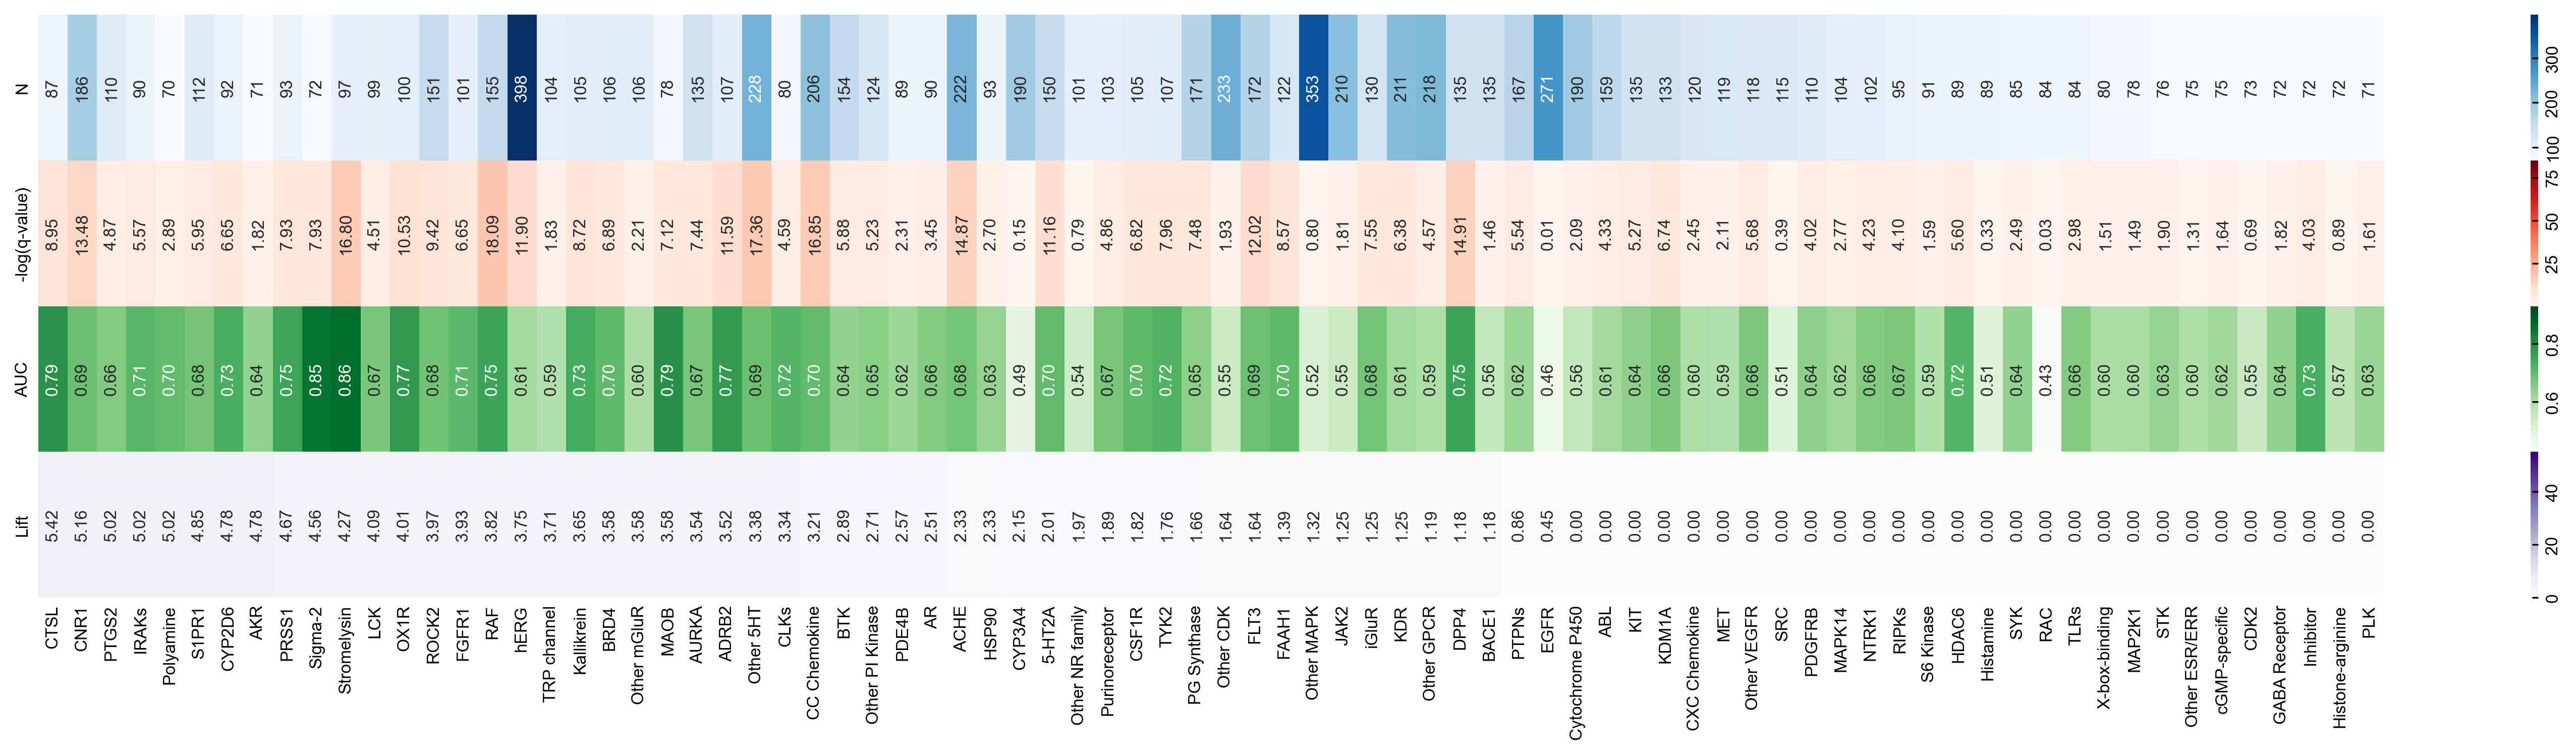

In [58]:
d = {(altnames[lift_ordered_data[i][0]] if lift_ordered_data[i][0] in altnames else lift_ordered_data[i][0]): lift_ordered_data[i][1:][::-1] for i in range(len(names)//2, len(names))}

idx = ['Lift', 'AUC', '-log(q-value)', 'N'][::-1]
norms = [Normalize(vmin=min([d[i] for d in data]), vmax=max([d[i] for d in data])) for i in range(1, 5)][::-1]

df = pd.DataFrame(d, index = idx)
cm = ['Blues', 'Reds', 'Greens', 'Purples']
f, axs = plt.subplots(4, 1, gridspec_kw={'hspace': 0}, figsize=(25,5))
counter = 0
for index, row in df.iterrows():
    heatmap = sns.heatmap(np.array([row.values]), yticklabels=[idx[counter]], xticklabels=df.columns, annot=True, fmt=('.2f' if counter != 0 else '.0f'), annot_kws={'rotation': 90}, ax=axs[counter], norm=norms[counter], cmap=cm[counter], cbar=True)
    cbar = heatmap.collections[0].colorbar
    heatmap.tick_params(left=False, bottom=False)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')

    counter += 1

plt.show()